# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

---
### *Описание данных*

__*Данные геологоразведки трёх регионов находятся в файлах:*__
* geo_data_0.csv
* geo_data_1.csv
* geo_data_2.csv

Известны следующие признаки:
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек;

Целевой признак:
* product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from numpy.random import RandomState
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

Загрузим датасет с данными.

In [2]:
try:
    df = pd.read_csv('datasets/geo_data_0.csv')
    df_1 = pd.read_csv('datasets/geo_data_1.csv')
    df_2 = pd.read_csv('datasets/geo_data_2.csv')
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
names = [df, df_1, df_2]
for name in names:
    print(name.columns)

Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')
Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')
Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')


Изучим наши данные, чтобы определить для себя возможные первичные действия по предобработке данных.

In [4]:
df.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
for name in names:
    print(name.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

Пропусков в данных не обнаружено. Стиль наименования столбцов соответствует snake_case. Можно оптимизировать размерность данных в 4 количественных столбцах, где тип данных соответствует float64.

---
### *Обработка дубликатов*

Поищем явные дубликаты в данных по имеющейся переменной `id`.

In [6]:
for name in names:
    print(name['id'].duplicated().sum())

10
4
4


In [7]:
for name in names:
    name.drop_duplicates(subset=['id'], inplace=True)
    name.reset_index(drop=True, inplace=True)

In [8]:
for name in names:
    print(name['id'].duplicated().sum())

0
0
0


In [9]:
# Объединение DataFrame'ов по вертикали
merged_df = pd.concat([df, df_1, df_2])

# Проверка дубликатов в столбце 'id'
duplicates = merged_df[merged_df.duplicated(['id'])]['id']
print(f'Число обнаруженных дубликатов между DF: {len(duplicates)}')

# Восстановление изначальных DataFrame'ов с учетом удаленных дубликатов

df = df.query('id not in @duplicates')
df_1 = df_1.query('id not in @duplicates')
df_2 = df_2.query('id not in @duplicates')

Число обнаруженных дубликатов между DF: 31


Уберем неинформативный далее для нас признак - `id`.

In [10]:
df = df.drop(['id'], axis=1)
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)

---
### *Изменение типов данных*

In [11]:
fcols = df.select_dtypes('float').columns
icols = df.select_dtypes('integer').columns

df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df_1[fcols] = df_1[fcols].apply(pd.to_numeric, downcast='float')
df_2[fcols] = df_2[fcols].apply(pd.to_numeric, downcast='float')

Типы данных успешно преобразованы.

---
### *Обработка аномальных значений*

В данных могут встречаться артефакты (аномалии) — значения, которые не отражают действительность и появились по какой-то ошибке.

In [12]:
(
    df[df.select_dtypes(['float32']).columns]
    .quantile([0.0012, 0.01, .5, .99, .9988])  # выбираем размах в 0,9976 квантилей
    .style.format("{:,.2f}")
)

,f0,f1,f2,product
0.0012,-1.18,-0.72,-6.97,0.61
0.01,-1.08,-0.62,-4.97,4.91
0.5,0.50,0.25,2.52,91.84
0.99,2.08,1.12,9.97,180.35
0.9988,2.19,1.22,12.07,184.70


In [13]:
(
    df_1[df_1.select_dtypes(['float32']).columns]
    .quantile([0.0012, 0.01, .5, .99, .9988])  # выбираем размах в 0,9976 квантилей
    .style.format("{:,.2f}")
)

,f0,f1,f2,product
0.0012,-20.33,-20.14,-0.01,0.00
0.01,-16.54,-16.58,-0.01,0.00
0.5,1.15,-4.81,2.01,57.09
0.99,18.86,7.14,5.01,137.95
0.9988,22.87,10.87,5.01,137.95


In [14]:
(
    df_2[df_2.select_dtypes(['float32']).columns]
    .quantile([0.0012, 0.01, .5, .99, .9988])  # выбираем размах в 0,9976 квантилей
    .style.format("{:,.2f}")
)

,f0,f1,f2,product
0.0012,-5.24,-5.24,-7.77,0.60
0.01,-4.02,-4.00,-5.50,5.10
0.5,0.01,-0.01,2.48,94.91
0.99,4.06,4.02,10.51,185.00
0.9988,5.28,5.27,12.79,189.46


Все количественные данные проходят проверку на адекватность, аномальных выбросов не обнаружено.

## Исследование задачи

Проверка независимых переменных на мультиколлинеарность.

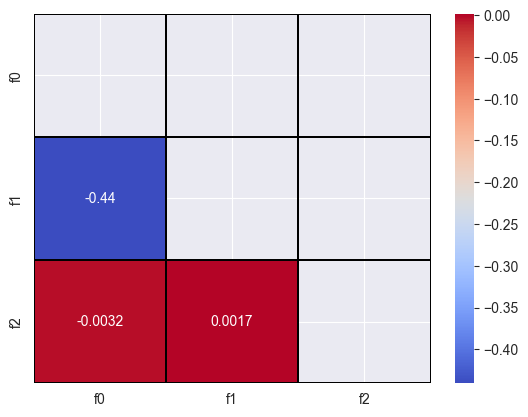

In [15]:
def matrix(df):
    matrix = np.triu(df.drop('product', axis=1).corr())
    sns.heatmap(df.drop('product', axis=1).corr(), annot=True, mask=matrix, cmap='coolwarm', linewidths=0.1,
                linecolor='black');


matrix(df)

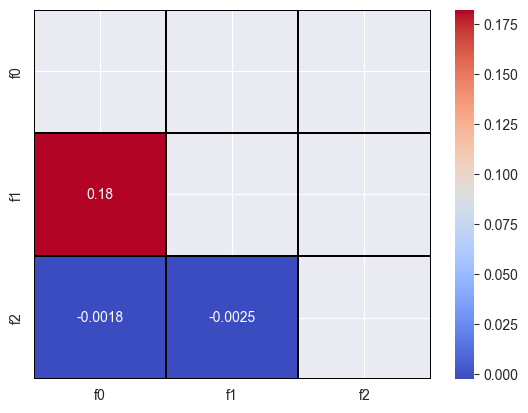

In [16]:
matrix(df_1)

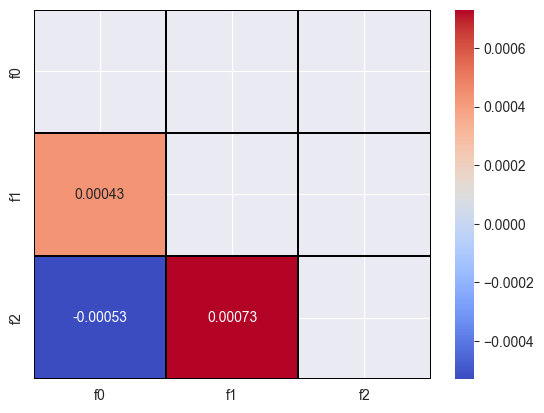

In [17]:
matrix(df_2)

Значения коллинеарности независимых признаков между собой не превышают критического значения в 0.7-0.8.

## Обучение и проверка модели

In [18]:
def calculate(df):
    features_train, features_test, target_train, target_test = train_test_split(df.drop(columns=['product']),
                                                                                df['product'], test_size=0.25,
                                                                                random_state=12345)
    pipeline = make_pipeline(StandardScaler(), LinearRegression())
    pipeline.fit(features_train, target_train)
    predict = pipeline.predict(features_test)
    region_df = pd.DataFrame({'prediction': predict, 'true': target_test}).reset_index(drop=True)
    rmse = mean_squared_error(target_test, predict, squared=False)
    r2 = r2_score(target_test, predict)
    return region_df, rmse, r2

In [ ]:
names = {'первого региона': df, 'второго региона': df_1, 'третьего региона': df_2}
for name in names:
    print(f'Средний запас предсказанного сырья для {name}: {calculate(names[name])[0]["prediction"].mean():.2f}',
          f'RMSE регрессионной модели для {name}: {calculate(names[name])[1]:.2f}',
          f'Коэффициент детерминации регрессионной модели для {name}: {calculate(names[name])[2]:.2f}', sep='\n')
    print()

Полученные результаты можно интерпретировать следующим образом, что модель линейной регрессии показывает впечатляющий результат (коэф. детрминации/r2 score = 1) на основе данных по второму региону. Для других же регионов предсказательная способность модели оставляет желать лучшего.

## Подготовка к расчёту прибыли

In [ ]:
# Перезапишем нужные нам в дальнейшем данные на исходные переменные df.
df = calculate(df)[0]
df_1 = calculate(df_1)[0]
df_2 = calculate(df_2)[0]

In [ ]:
EXPENSES = 10 ** 10
BARREL_COST = 450000
NUMBER_OF_OIL = 200
minimal_necessary_stocks = EXPENSES / BARREL_COST / NUMBER_OF_OIL
print(f'Минимально необходимый запас сырья в каждой из 200 скважин: {minimal_necessary_stocks:.2f} тыс. баррелей')

Подсчитав минимально необходимый запас сырья в каждой из 200 скважин для окупа вложенных затрат на разработку региона, мы можем прийти к выводу, что предсказанное среднее объема для всех 3 регионов меньше необходимого.

## Расчёт прибыли и рисков 

In [ ]:
def profit_calculation(data):
    return data.sort_values(by='prediction', ascending=False)[:NUMBER_OF_OIL][
        'true'].sum() * BARREL_COST - EXPENSES


def bootstrap(data):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = data.sample(n=500, replace=True, random_state=state)  # < напишите код здесь>)
        values.append(profit_calculation(target_subsample))
    return pd.Series(values)


def confidence_interval(data):
    return st.t.interval(confidence=0.95, df=len(data) - 1, loc=data.mean(), scale=data.sem())

In [ ]:
names = {'первого региона': df, 'второго региона': df_1, 'третьего региона': df_2}
for name in names:
    print(f'Средняя прибыль для {name}: {bootstrap(names[name]).mean() / 10 ** 6:.2f} млн. рублей.',
          f'95% доверительный интервал для {name}: от {bootstrap(names[name]).sort_values().quantile(0.025) / 10 ** 6:.2f}'
          f' до {bootstrap(names[name]).sort_values().quantile(0.975) / 10 ** 6:.2f}',
          f'Риск убытка для {name}: {(bootstrap(names[name]) < 0).mean():.2%}',
          sep='\n'
          )
    print()

---
## Общий вывод по исследованию

<div style="border:solid orange 2px; padding: 5px">

<div class="alert alert-info"> <b>При проведении исследования (на основе полученных данных) выполнено:</b></div>

- Обнаружены и удалены дубликаты в данных.
- Произведена оптимизация формата размерности количественных данных.
- Проведена проверка отсутствия мультиколлинеарности независимых признаков.
- Данные подготовлены к дальнейшему использованию при построении модели.
- Произведено масштабирование независимых количественных признаков.
- Создана функция для обучения модели линейной регрессии на основе данных для каждого региона, создан pipeline куда вошли масштабирование и сама модель линейной регрессии.
- Полученные результаты можно интерпретировать следующим образом, что модель линейной регрессии показывает впечатляющий результат (коэф. детрминации/r2 score = 1) на основе данных по второму региону. Для других же регионов предсказательная способность модели оставляет желать лучшего.
    - Первый регион:
        - Средний запас предсказанного сырья для первого региона: 92.72
        - RMSE регрессионной модели для первого региона: 37.84
        - Коэффициент детерминации регрессионной модели для первого региона: 0.27
    - Второй регион:
        - Средний запас предсказанного сырья для второго региона: 68.77
        - RMSE регрессионной модели для второго региона: 0.89
        - Коэффициент детерминации регрессионной модели для второго региона: 1.00
    - Третий регион:
        - Средний запас предсказанного сырья для третьего региона: 95.10
        - RMSE регрессионной модели для третьего региона: 39.94
        - Коэффициент детерминации регрессионной модели для третьего региона: 0.20

- Минимально необходимый запас сырья в каждой из 200 скважин для окупа вложенных затрат на разработку региона: 111.11 тыс. баррелей.
- Рассчитана прибыль и риски для каждого из регионов:
    - Первый регион:
        - Средняя прибыль для первого региона: 436.39 млн. рублей.
        - 95% доверительный интервал для первого региона: от -63.30 до 958.97
        - Риск убытка для первого региона: 4.00%
    - Второй регион:
        - Средняя прибыль для второго региона: 429.83 млн. рублей.
        - 95% доверительный интервал для второго региона: от 63.13 до 826.66
        - Риск убытка для второго региона: 1.40%
    - Третий регион:
        - Средняя прибыль для третьего региона: 355.00 млн. рублей.
        - 95% доверительный интервал для третьего региона: от -179.25 до 859.70
        - Риск убытка для третьего региона: 10.30%

- Из представленных трех регионов выбран второй регион, как регион с рисками убытка менее 2.5%.
